<a href="https://colab.research.google.com/github/Manolonava1602/Curso-Phyton-Tarea-1/blob/main/Actividad_2buena.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ACTIVIDAD 2: REDES NEURONALES CONVOLUCIONALES

---

En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Carga de los datos

In [ ]:
import cv2
import os
import numpy as np
import keras
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf



In [ ]:
!pip install keras_preprocessing

In [ ]:
import keras_preprocessing
print("El módulo Keras Preprocessing está instalado.")

El módulo Keras Preprocessing está instalado.


In [ ]:
!pip install scikit-learn==1.0.2

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.models import load_model
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
plt.rcParams["figure.figsize"] = (20,6)

In [ ]:
# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz",
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets


# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz",
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

10658925/10658925 [==============================] - 0s 0us/step


In [ ]:
# Descomprimimos el archivo en tmp para visualizar
# !tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /tmp/simpsons

In [ ]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel',
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson',
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak',
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 60

In [ ]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.

    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.

    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas

    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [ ]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [ ]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [ ]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

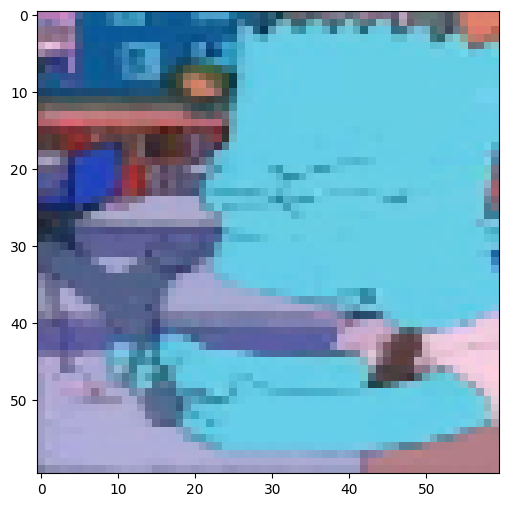

In [ ]:
plt.imshow(X_t[2])

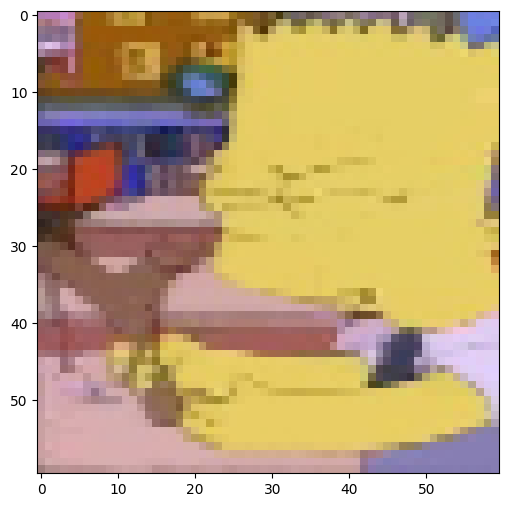

In [ ]:
plt.imshow(np.flip(X_t[2], axis=-1) )

## Ejercicio

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de, al menos, **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos para ser analizados en vuestro informe:

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas:
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

In [1]:
!pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 771.9 kB/s eta 0:00:00


In [2]:
import os
import cv2
import glob
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, Xception, ResNet50, InceptionV3, EfficientNetB7
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.models import load_model
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tensorflow import keras
plt.rcParams["figure.figsize"] = (20,6)


def preprocess_data(X, y):
    # Normalizamos las imágenes y convertimos las etiquetas a one-hot encoding
    X = X / 255.0
    y = to_categorical(y, num_classes=len(MAP_CHARACTERS))
    return X, y

def create_cnn_model(base_model, input_shape):
    # Creamos un modelo de CNN utilizando el modelo base dado
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(len(MAP_CHARACTERS), activation='softmax'))
    return model

def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, batch_size, epochs):
    # Compilamos y entrenamos el modelo
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)
    return model, history

def plot_training_history(history):
    # Función para visualizar la historia de entrenamiento
    # (puedes utilizar matplotlib o cualquier otra biblioteca de visualización)
    pass

def analyze_results(model, X_test, y_test):
    # Realizamos predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Evaluamos el rendimiento del modelo
    print("Classification Report:\n", classification_report(y_test, y_pred_classes))

    # Matriz de confusión
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_classes))

    # Puedes añadir más análisis aquí según las necesidades

def visualize_errors(model, X_test, y_test, label_mapping):
    # Visualización de imágenes que fueron clasificadas incorrectamente
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    misclassified_indices = np.where(y_pred_classes != y_test)[0]

    for i in misclassified_indices[:10]:  # Visualizamos los primeros 10 errores
        true_label = label_mapping[y_test[i]]
        predicted_label = label_mapping[y_pred_classes[i]]
        print(f"True Label: {true_label}, Predicted Label: {predicted_label}")

        # Aquí puedes agregar la visualización de las imágenes

def compare_models(X_train, y_train, X_val, y_val, X_test, y_test):
    # Comparación de modelos CNN con Fully Connected
    cnn_models = [
        ("VGG16", VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))),
        ("Xception", Xception(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))),
        ("ResNet50", ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))),
        ("InceptionV3", InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))),
        ("EfficientNetB7", EfficientNetB7(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))),
    ]

    fully_connected_model = models.Sequential()
    fully_connected_model.add(layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    fully_connected_model.add(layers.Dense(512, activation='relu'))
    fully_connected_model.add(layers.Dropout(0.5))
    fully_connected_model.add(layers.Dense(len(MAP_CHARACTERS), activation='softmax'))

    models_results = []

    for model_name, base_model in cnn_models:
        cnn_model = create_cnn_model(base_model, (IMG_SIZE, IMG_SIZE, 3))
        cnn_model, history = train_and_evaluate_model(cnn_model, X_train, y_train, X_val, y_val, batch_size=32, epochs=5)
        cnn_accuracy = cnn_model.evaluate(X_test, y_test, verbose=0)[1]
        models_results.append((model_name, cnn_accuracy))

    fully_connected_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    fully_connected_history = fully_connected_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)
    fully_connected_accuracy = fully_connected_model.evaluate(X_test, y_test, verbose=0)[1]
    models_results.append(("Fully Connected", fully_connected_accuracy))

    # Puedes imprimir o visualizar los resultados aquí

def apply_data_augmentation(X_train):
    # Aplicamos data augmentation utilizando ImageDataGenerator
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    augmented_images = []
    for image in X_train:
        augmented_image = datagen.random_transform(image)
        augmented_images.append(augmented_image)

    return np.array(augmented_images)

def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.

    Como las imágenes tienen tamaños distintos, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.

    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas

    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
            print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image, (IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz",
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets


# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz",
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets


# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel',
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson',
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak',
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 75

DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)

# Cargamos los datos
X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS, verbose=False)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS, verbose=False)


# Preprocesamos los datos
X, y = preprocess_data(X, y)
X_t, y_t = preprocess_data(X_t, y_t)


10658925/10658925 [==============================] - 2s 0us/step


In [3]:
# Dividimos los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicamos data augmentation
X_train_augmented = apply_data_augmentation(X_train)


def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, batch_size, epochs):
    # Compilamos y entrenamos el modelo
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)
    return model, history

# Función para obtener el nombre de la capa de salida de un modelo dado
def get_output_layer_name(model):
    return model.layers[-1].name

def create_cnn_model(base_model, input_shape):
    # Creamos un modelo de CNN utilizando el modelo base dado
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(len(MAP_CHARACTERS), activation='softmax'))
    return model

def plot_training_history(history):
    # Función para visualizar la historia de entrenamiento
    import matplotlib.pyplot as plt

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()




258076736/258076736 [==============================] - 1s 0us/step
Epoch 1/10
475/475 [==============================] - 23s 31ms/step - loss: 2.7321 - accuracy: 0.1312 - val_loss: 2.3341 - val_accuracy: 0.2409
Epoch 2/10
475/475 [==============================] - 12s 26ms/step - loss: 2.2245 - accuracy: 0.2643 - val_loss: 2.0354 - val_accuracy: 0.3380
Epoch 3/10
475/475 [==============================] - 12s 25ms/step - loss: 1.8759 - accuracy: 0.3962 - val_loss: 1.7021 - val_accuracy: 0.4546
Epoch 4/10
475/475 [==============================] - 12s 25ms/step - loss: 1.5167 - accuracy: 0.5147 - val_loss: 1.4636 - val_accuracy: 0.5375
Epoch 5/10
475/475 [==============================] - 12s 25ms/step - loss: 1.2745 - accuracy: 0.5943 - val_loss: 1.2651 - val_accuracy: 0.6317
Epoch 6/10
475/475 [==============================] - 12s 25ms/step - loss: 1.1018 - accuracy: 0.6594 - val_loss: 1.0801 - val_accuracy: 0.6683
Epoch 7/10
475/475 [==============================] - 12s 26ms/step -

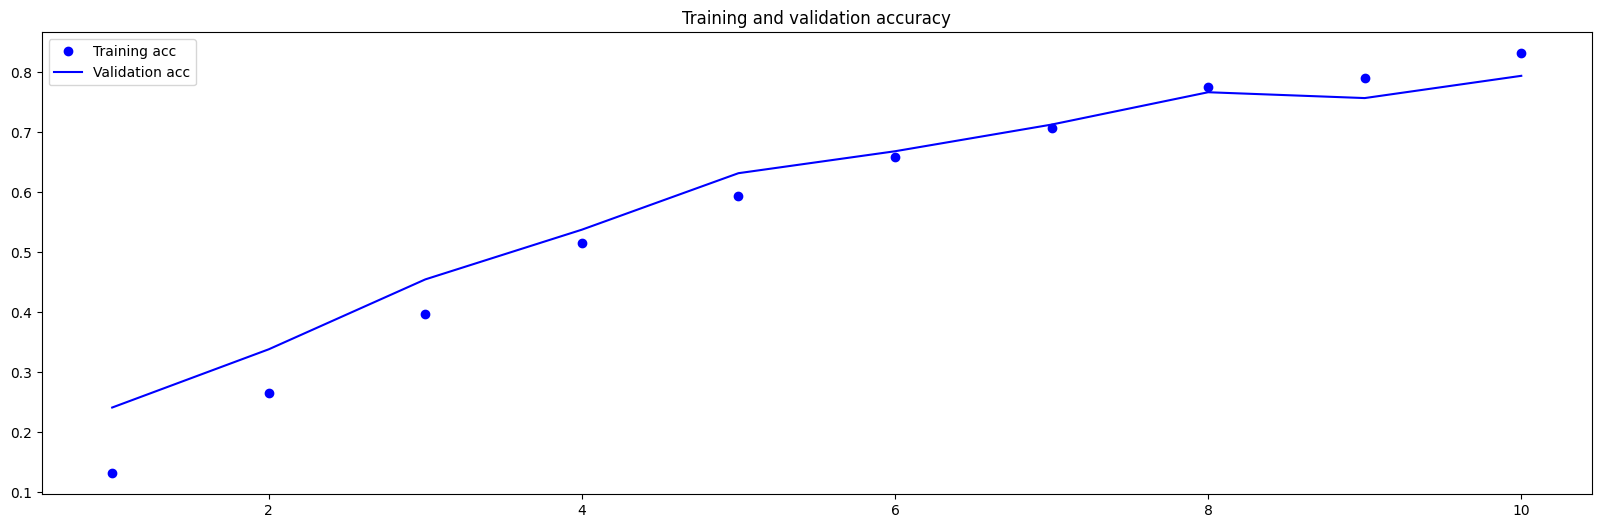

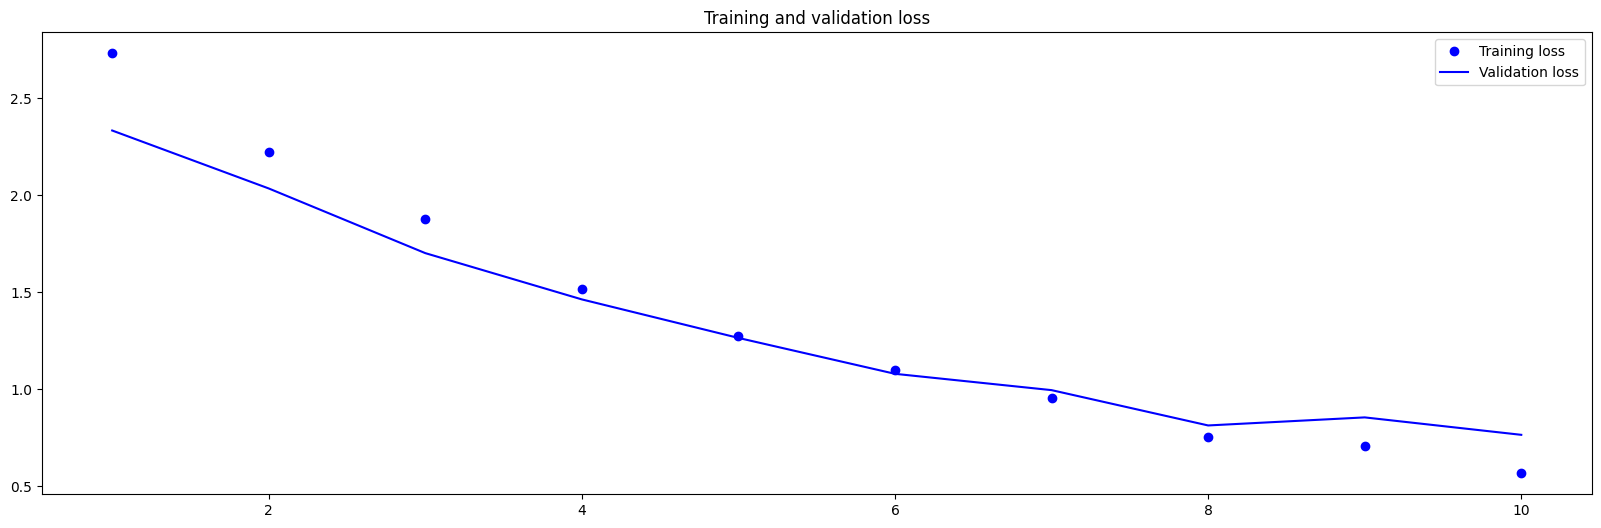

Epoch 1/10
475/475 [==============================] - 42s 41ms/step - loss: 2.3551 - accuracy: 0.2901 - val_loss: 4.6741 - val_accuracy: 0.3325
Epoch 2/10
475/475 [==============================] - 17s 35ms/step - loss: 0.9679 - accuracy: 0.7288 - val_loss: 2.0806 - val_accuracy: 0.6875
Epoch 3/10
475/475 [==============================] - 17s 35ms/step - loss: 0.5236 - accuracy: 0.8669 - val_loss: 0.6505 - val_accuracy: 0.8479
Epoch 4/10
475/475 [==============================] - 17s 35ms/step - loss: 0.3097 - accuracy: 0.9206 - val_loss: 0.5738 - val_accuracy: 0.8665
Epoch 5/10
475/475 [==============================] - 17s 35ms/step - loss: 0.2494 - accuracy: 0.9372 - val_loss: 0.5292 - val_accuracy: 0.8744
Epoch 6/10
475/475 [==============================] - 17s 35ms/step - loss: 0.2094 - accuracy: 0.9478 - val_loss: 0.5940 - val_accuracy: 0.8971
Epoch 7/10
475/475 [==============================] - 17s 35ms/step - loss: 0.1617 - accuracy: 0.9595 - val_loss: 0.4760 - val_accuracy:

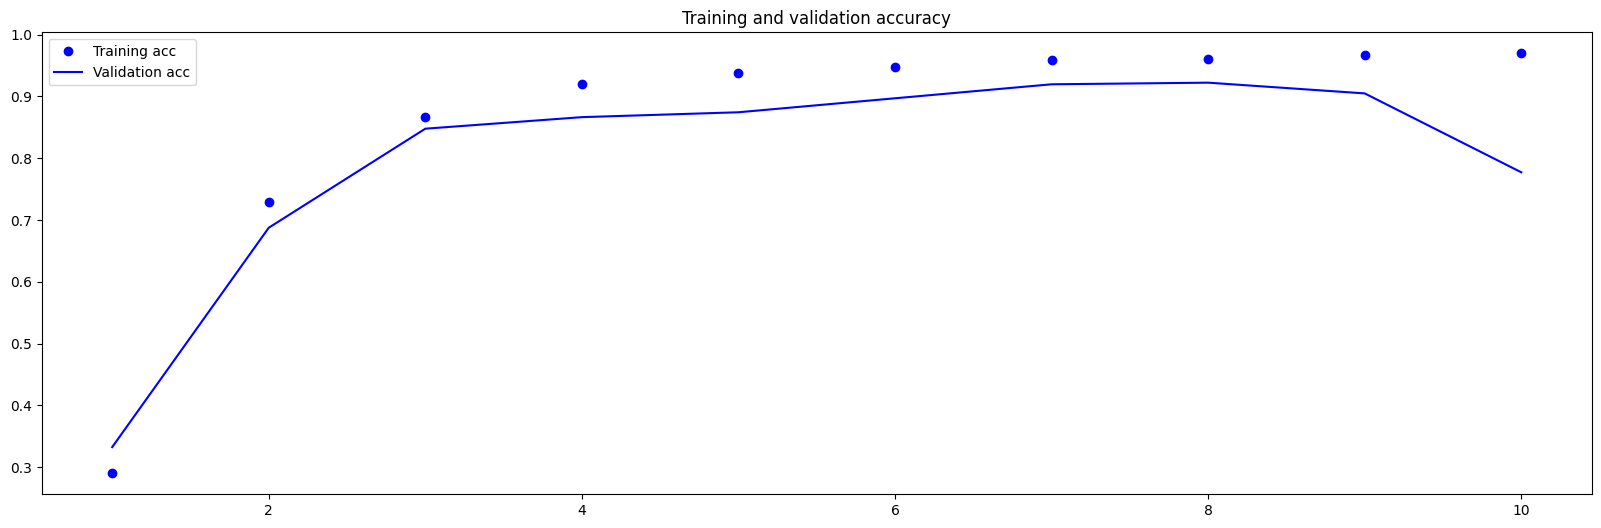

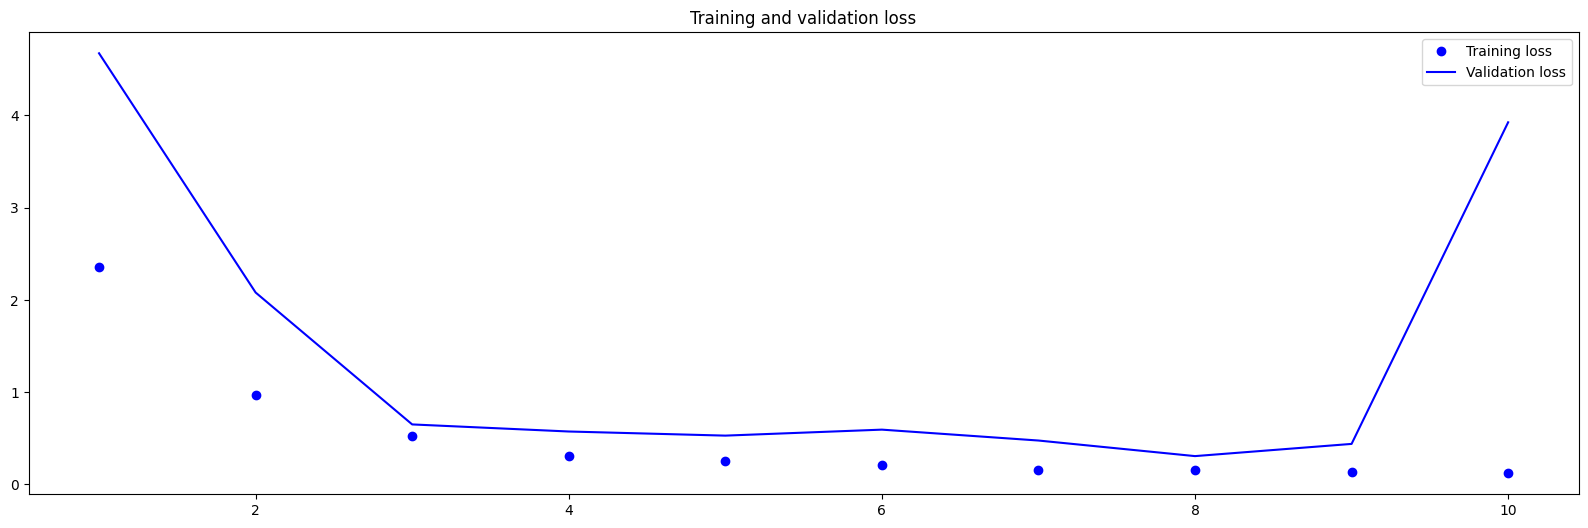

Epoch 1/10
475/475 [==============================] - 53s 49ms/step - loss: 1.6872 - accuracy: 0.5718 - val_loss: 2.9141 - val_accuracy: 0.0445
Epoch 2/10
475/475 [==============================] - 20s 43ms/step - loss: 1.0772 - accuracy: 0.7028 - val_loss: 2.8543 - val_accuracy: 0.1050
Epoch 3/10
475/475 [==============================] - 20s 42ms/step - loss: 0.8937 - accuracy: 0.7469 - val_loss: 1.3221 - val_accuracy: 0.6433
Epoch 4/10
475/475 [==============================] - 20s 43ms/step - loss: 1.0938 - accuracy: 0.6895 - val_loss: 1.5889 - val_accuracy: 0.5486
Epoch 5/10
475/475 [==============================] - 20s 43ms/step - loss: 1.0442 - accuracy: 0.6997 - val_loss: 1.7834 - val_accuracy: 0.5328
Epoch 6/10
475/475 [==============================] - 20s 43ms/step - loss: 0.7216 - accuracy: 0.7912 - val_loss: 1.3106 - val_accuracy: 0.6399
Epoch 7/10
475/475 [==============================] - 20s 43ms/step - loss: 0.6499 - accuracy: 0.8145 - val_loss: 1.1526 - val_accuracy:

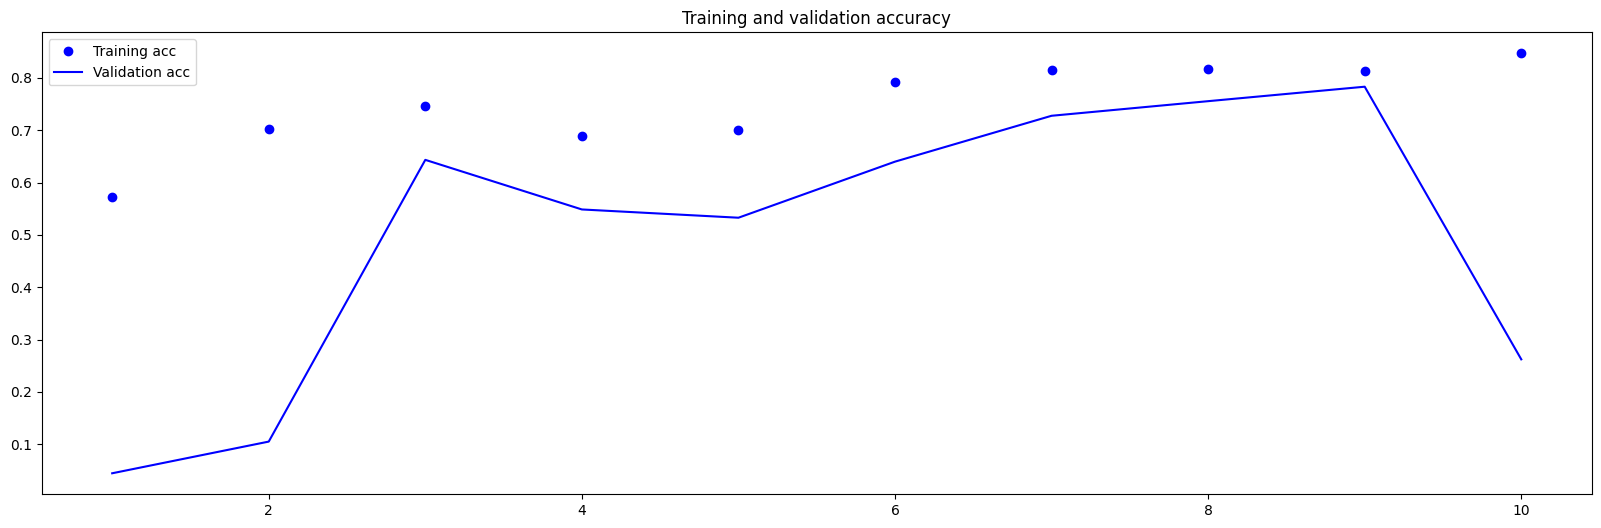

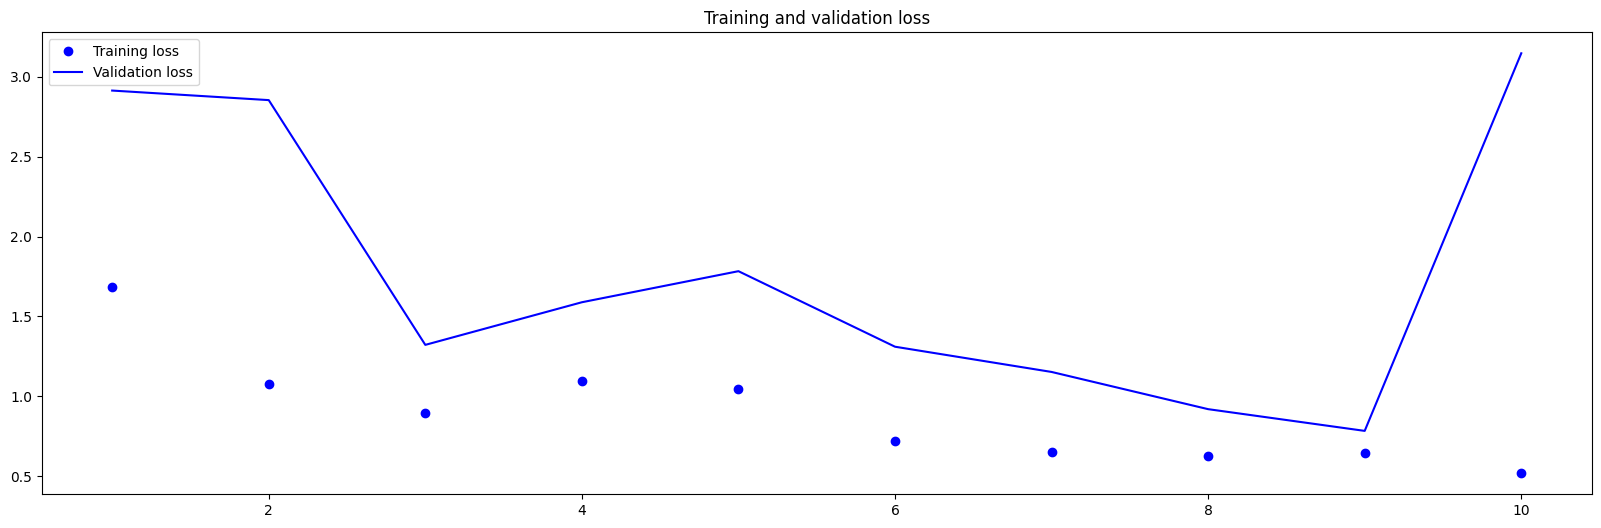

Epoch 1/10
475/475 [==============================] - 58s 57ms/step - loss: 2.8982 - accuracy: 0.1097 - val_loss: 50.6328 - val_accuracy: 0.0819
Epoch 2/10
475/475 [==============================] - 23s 48ms/step - loss: 2.6801 - accuracy: 0.1485 - val_loss: 1193.7990 - val_accuracy: 0.1258
Epoch 3/10
475/475 [==============================] - 23s 48ms/step - loss: 2.6097 - accuracy: 0.1521 - val_loss: 3.8805 - val_accuracy: 0.0600
Epoch 4/10
475/475 [==============================] - 23s 48ms/step - loss: 2.3807 - accuracy: 0.1953 - val_loss: 2.5468 - val_accuracy: 0.1848
Epoch 5/10
475/475 [==============================] - 23s 48ms/step - loss: 2.2311 - accuracy: 0.2422 - val_loss: 2.6273 - val_accuracy: 0.1521
Epoch 6/10
475/475 [==============================] - 23s 49ms/step - loss: 2.2816 - accuracy: 0.2333 - val_loss: 2.8423 - val_accuracy: 0.1485
Epoch 7/10
475/475 [==============================] - 23s 48ms/step - loss: 2.1874 - accuracy: 0.2701 - val_loss: 3.7203 - val_accur

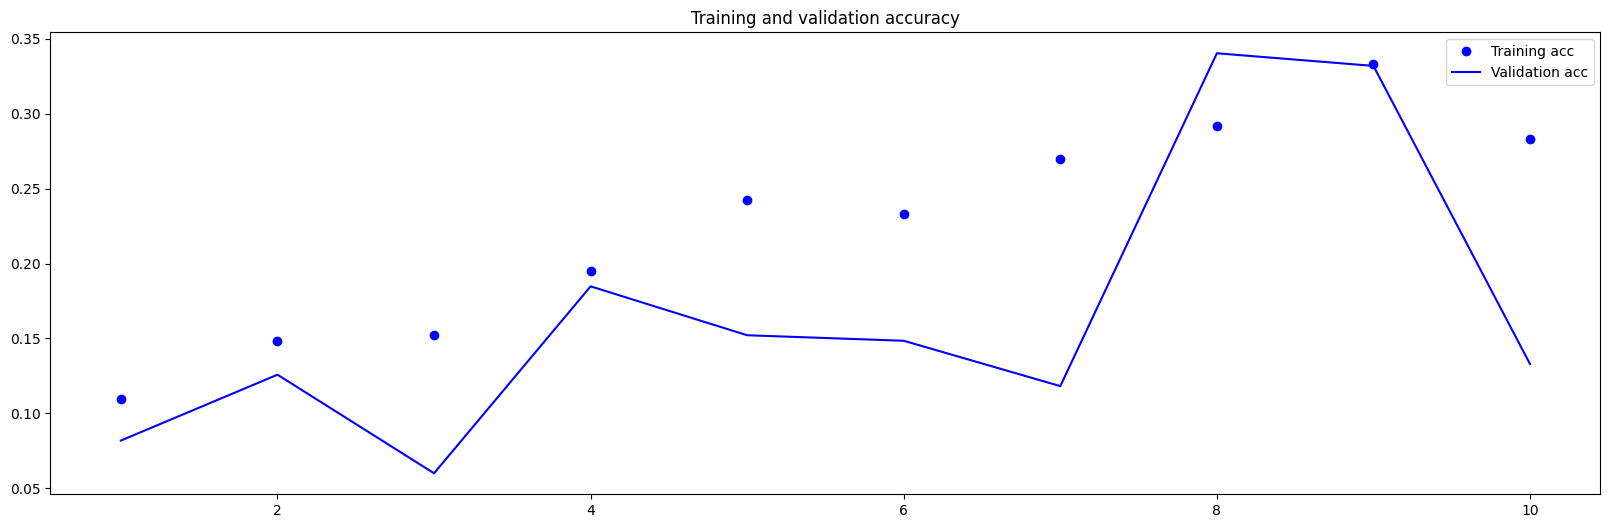

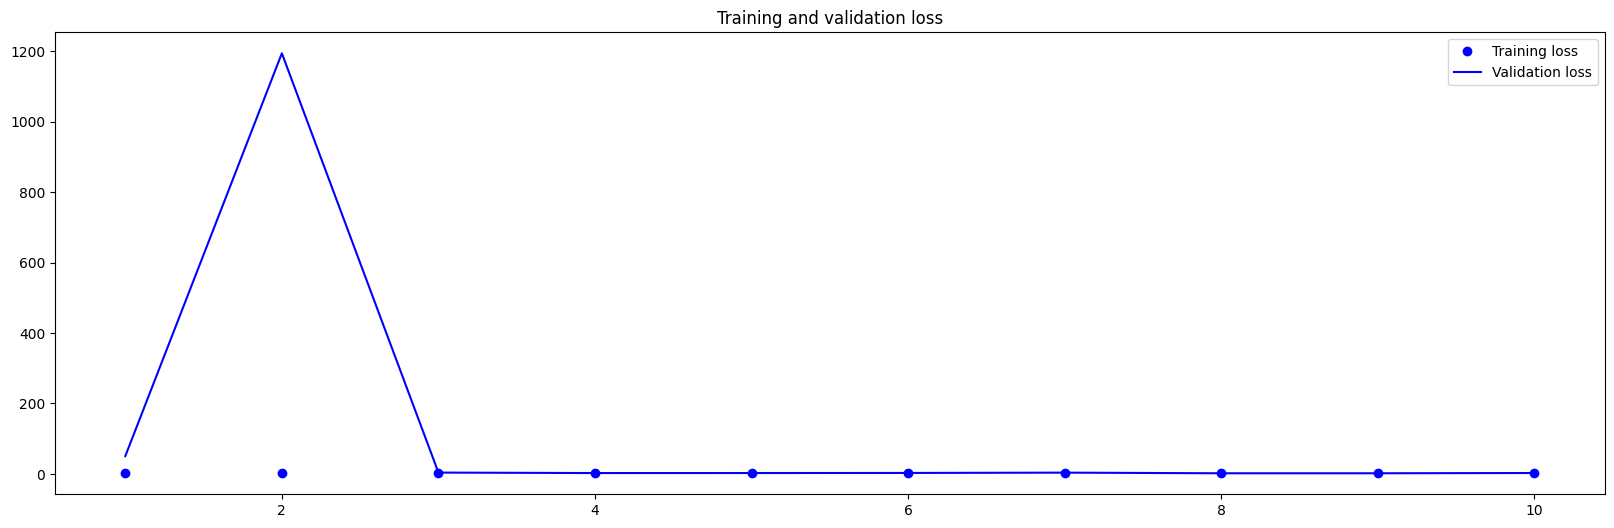

Epoch 1/10
475/475 [==============================] - 202s 174ms/step - loss: 2.0736 - accuracy: 0.3964 - val_loss: 3.7295 - val_accuracy: 0.0663
Epoch 2/10
475/475 [==============================] - 76s 160ms/step - loss: 1.0817 - accuracy: 0.7170 - val_loss: 2.7866 - val_accuracy: 0.2006
Epoch 3/10
475/475 [==============================] - 76s 160ms/step - loss: 0.7282 - accuracy: 0.8106 - val_loss: 2.8837 - val_accuracy: 0.0619
Epoch 4/10
475/475 [==============================] - 75s 159ms/step - loss: 0.5419 - accuracy: 0.8607 - val_loss: 2.9059 - val_accuracy: 0.0458
Epoch 5/10
475/475 [==============================] - 76s 159ms/step - loss: 0.4887 - accuracy: 0.8778 - val_loss: 2.6849 - val_accuracy: 0.2969
Epoch 6/10
475/475 [==============================] - 76s 159ms/step - loss: 0.4071 - accuracy: 0.8996 - val_loss: 3.7299 - val_accuracy: 0.0708
Epoch 7/10
475/475 [==============================] - 76s 159ms/step - loss: 0.3765 - accuracy: 0.9053 - val_loss: 2.8937 - val_a

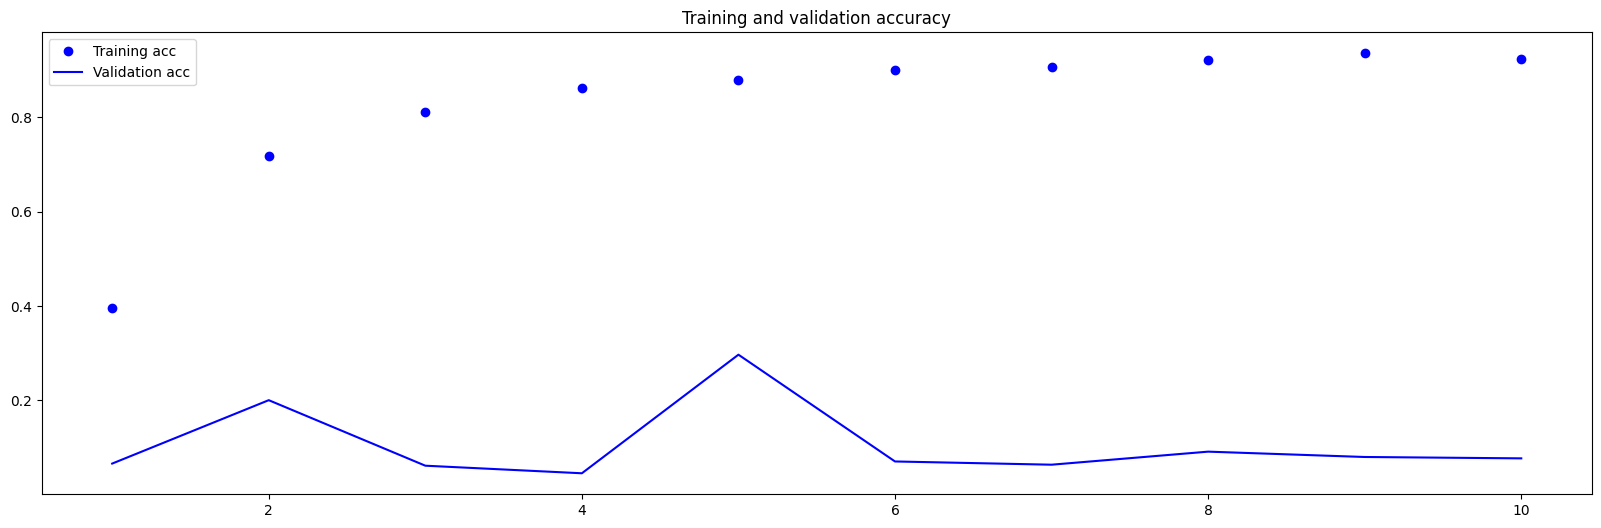

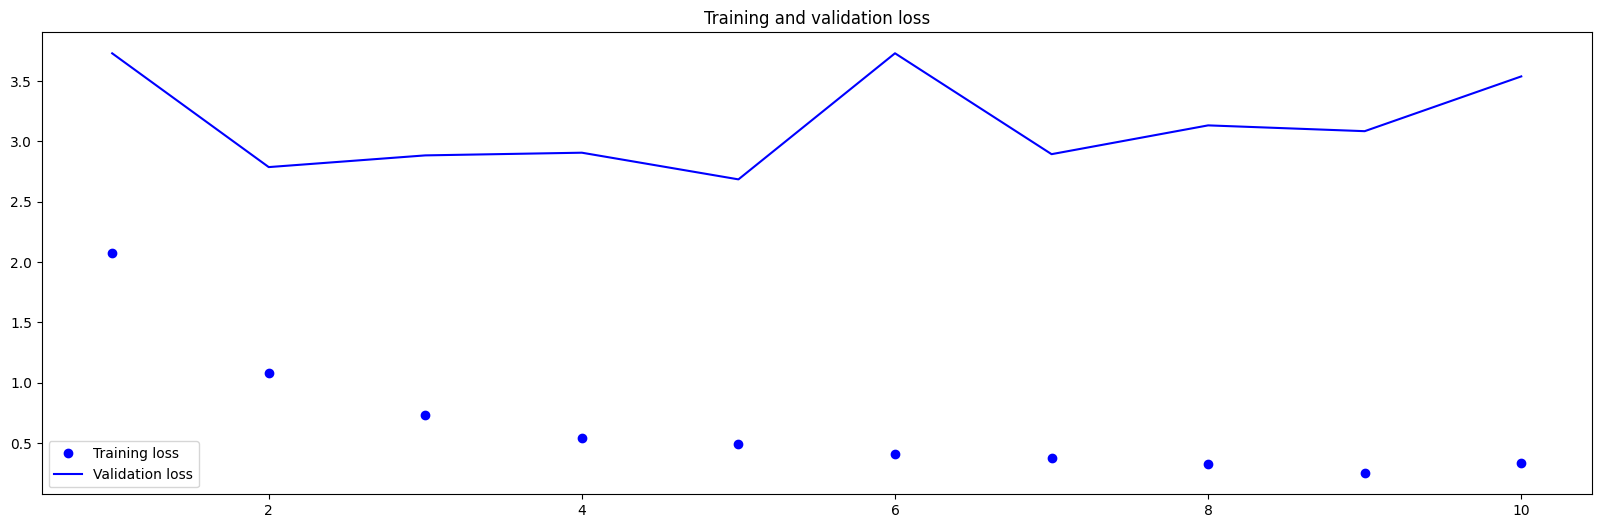

In [4]:
# Modelos pre-entrenados
vgg16_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
xception_base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
resnet50_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
inceptionv3_base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
efficientnetb7_base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Crear modelos CNN utilizando cada modelo base
vgg16_model = create_cnn_model(vgg16_base_model, (IMG_SIZE, IMG_SIZE, 3))
xception_model = create_cnn_model(xception_base_model, (IMG_SIZE, IMG_SIZE, 3))
resnet50_model = create_cnn_model(resnet50_base_model, (IMG_SIZE, IMG_SIZE, 3))
inceptionv3_model = create_cnn_model(inceptionv3_base_model, (IMG_SIZE, IMG_SIZE, 3))
efficientnetb7_model = create_cnn_model(efficientnetb7_base_model, (IMG_SIZE, IMG_SIZE, 3))

# Entrenar y evaluar modelos
epochs = 10
batch_size = 32

# VGG16
vgg16_model, vgg16_history = train_and_evaluate_model(vgg16_model, X_train, y_train, X_val, y_val, batch_size, epochs)
plot_training_history(vgg16_history)

# Xception
xception_model, xception_history = train_and_evaluate_model(xception_model, X_train, y_train, X_val, y_val, batch_size, epochs)
plot_training_history(xception_history)

# ResNet50
resnet50_model, resnet50_history = train_and_evaluate_model(resnet50_model, X_train, y_train, X_val, y_val, batch_size, epochs)
plot_training_history(resnet50_history)

# InceptionV3
inceptionv3_model, inceptionv3_history = train_and_evaluate_model(inceptionv3_model, X_train, y_train, X_val, y_val, batch_size, epochs)
plot_training_history(inceptionv3_history)

# EfficientNetB7
efficientnetb7_model, efficientnetb7_history = train_and_evaluate_model(efficientnetb7_model, X_train, y_train, X_val, y_val, batch_size, epochs)
plot_training_history(efficientnetb7_history)

28/28 [==============================] - 0s 8ms/step
True Label: moe_szyslak, Predicted Label: moe_szyslak


<ipython-input-30-cdb8be63b78e>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  misclassified_indices = np.where(y_pred_classes != y_test)[0]


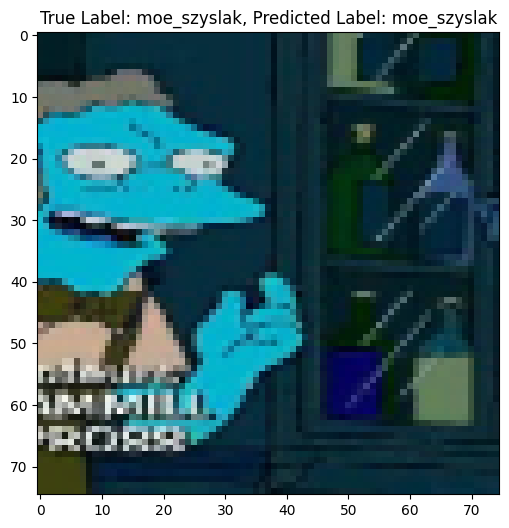

28/28 [==============================] - 0s 9ms/step
True Label: moe_szyslak, Predicted Label: moe_szyslak


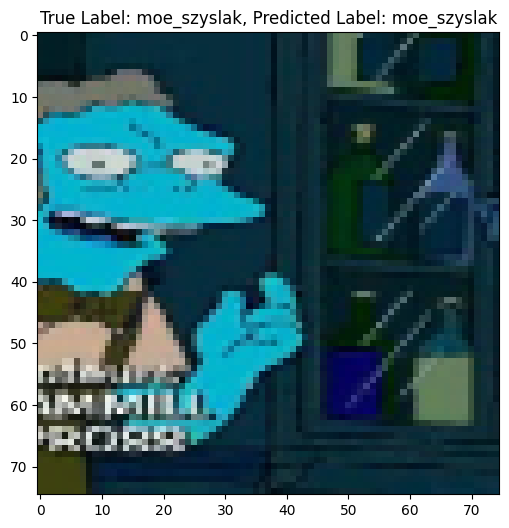

28/28 [==============================] - 0s 9ms/step
True Label: moe_szyslak, Predicted Label: chief_wiggum


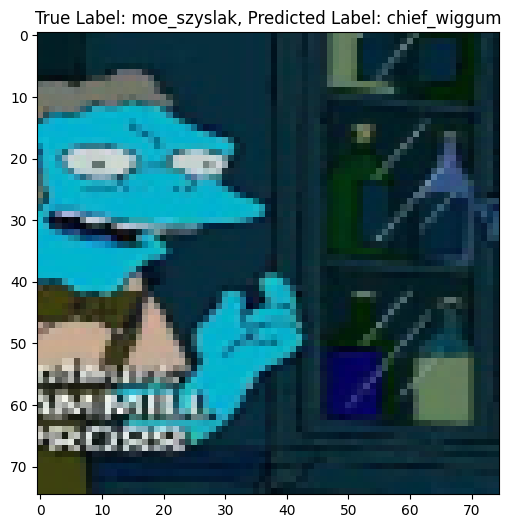

28/28 [==============================] - 0s 10ms/step
True Label: moe_szyslak, Predicted Label: chief_wiggum


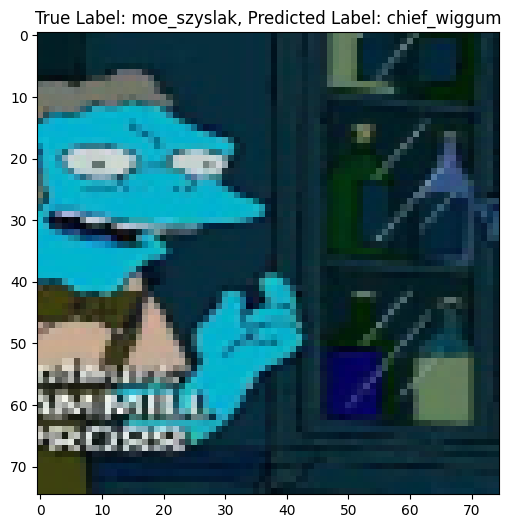

28/28 [==============================] - 1s 35ms/step
True Label: moe_szyslak, Predicted Label: ned_flanders


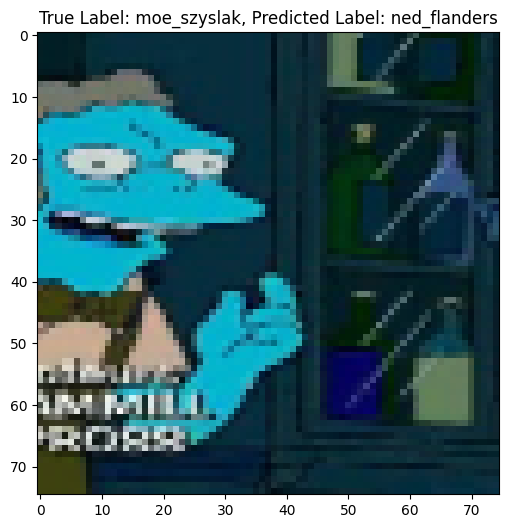

In [30]:
def visualize_errors1(model, X_test, y_test, label_mapping):
    # Visualización de imágenes que fueron clasificadas incorrectamente
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    misclassified_indices = np.where(y_pred_classes != y_test)[0]

    for i in misclassified_indices[:10]:  # Visualizamos los primeros 10 errores
        true_label = label_mapping[np.argmax(y_test[i])]
        predicted_label = label_mapping[y_pred_classes[i]]
        print(f"True Label: {true_label}, Predicted Label: {predicted_label}")

        # Visualizar la imagen
        plt.imshow(X_test[i])
        plt.title(f"True Label: {true_label}, Predicted Label: {predicted_label}")
        plt.show()

# Visualizar errores para cada modelo
visualize_errors1(vgg16_model, X_t, y_t, MAP_CHARACTERS)
visualize_errors1(xception_model, X_t, y_t, MAP_CHARACTERS)
visualize_errors1(resnet50_model, X_t, y_t, MAP_CHARACTERS)
visualize_errors1(inceptionv3_model, X_t, y_t, MAP_CHARACTERS)
visualize_errors1(efficientnetb7_model, X_t, y_t, MAP_CHARACTERS)


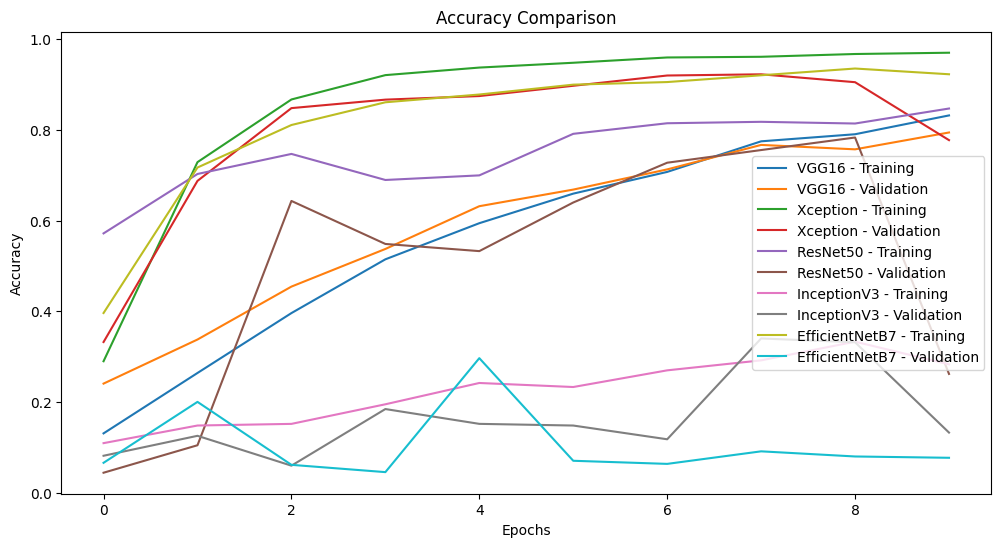

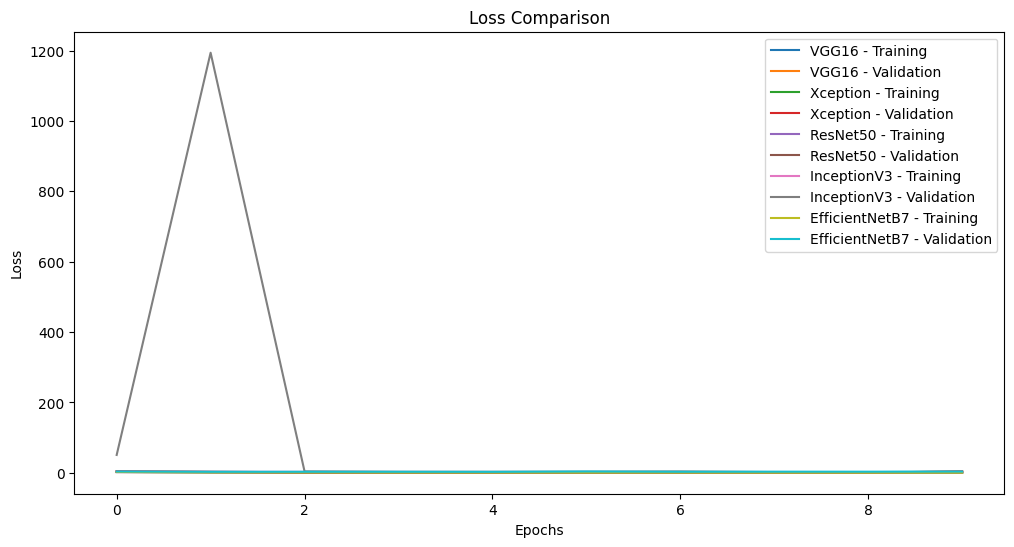

In [50]:
def plot_comparison(history_list, model_names, metric='accuracy'):
    plt.figure(figsize=(12, 6))

    for i, history in enumerate(history_list):
        plt.plot(history.history[metric], label=f'{model_names[i]} - Training')
        plt.plot(history.history[f'val_{metric}'], label=f'{model_names[i]} - Validation')

    plt.title(f'{metric.capitalize()} Comparison')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()

# Historiales de entrenamiento de cada modelo
history_list = [vgg16_history, xception_history, resnet50_history, inceptionv3_history, efficientnetb7_history]
model_names = ['VGG16', 'Xception', 'ResNet50', 'InceptionV3', 'EfficientNetB7']

# Graficar las curvas de precisión
plot_comparison(history_list, model_names, metric='accuracy')

# Graficar las curvas de pérdida
plot_comparison(history_list, model_names, metric='loss')


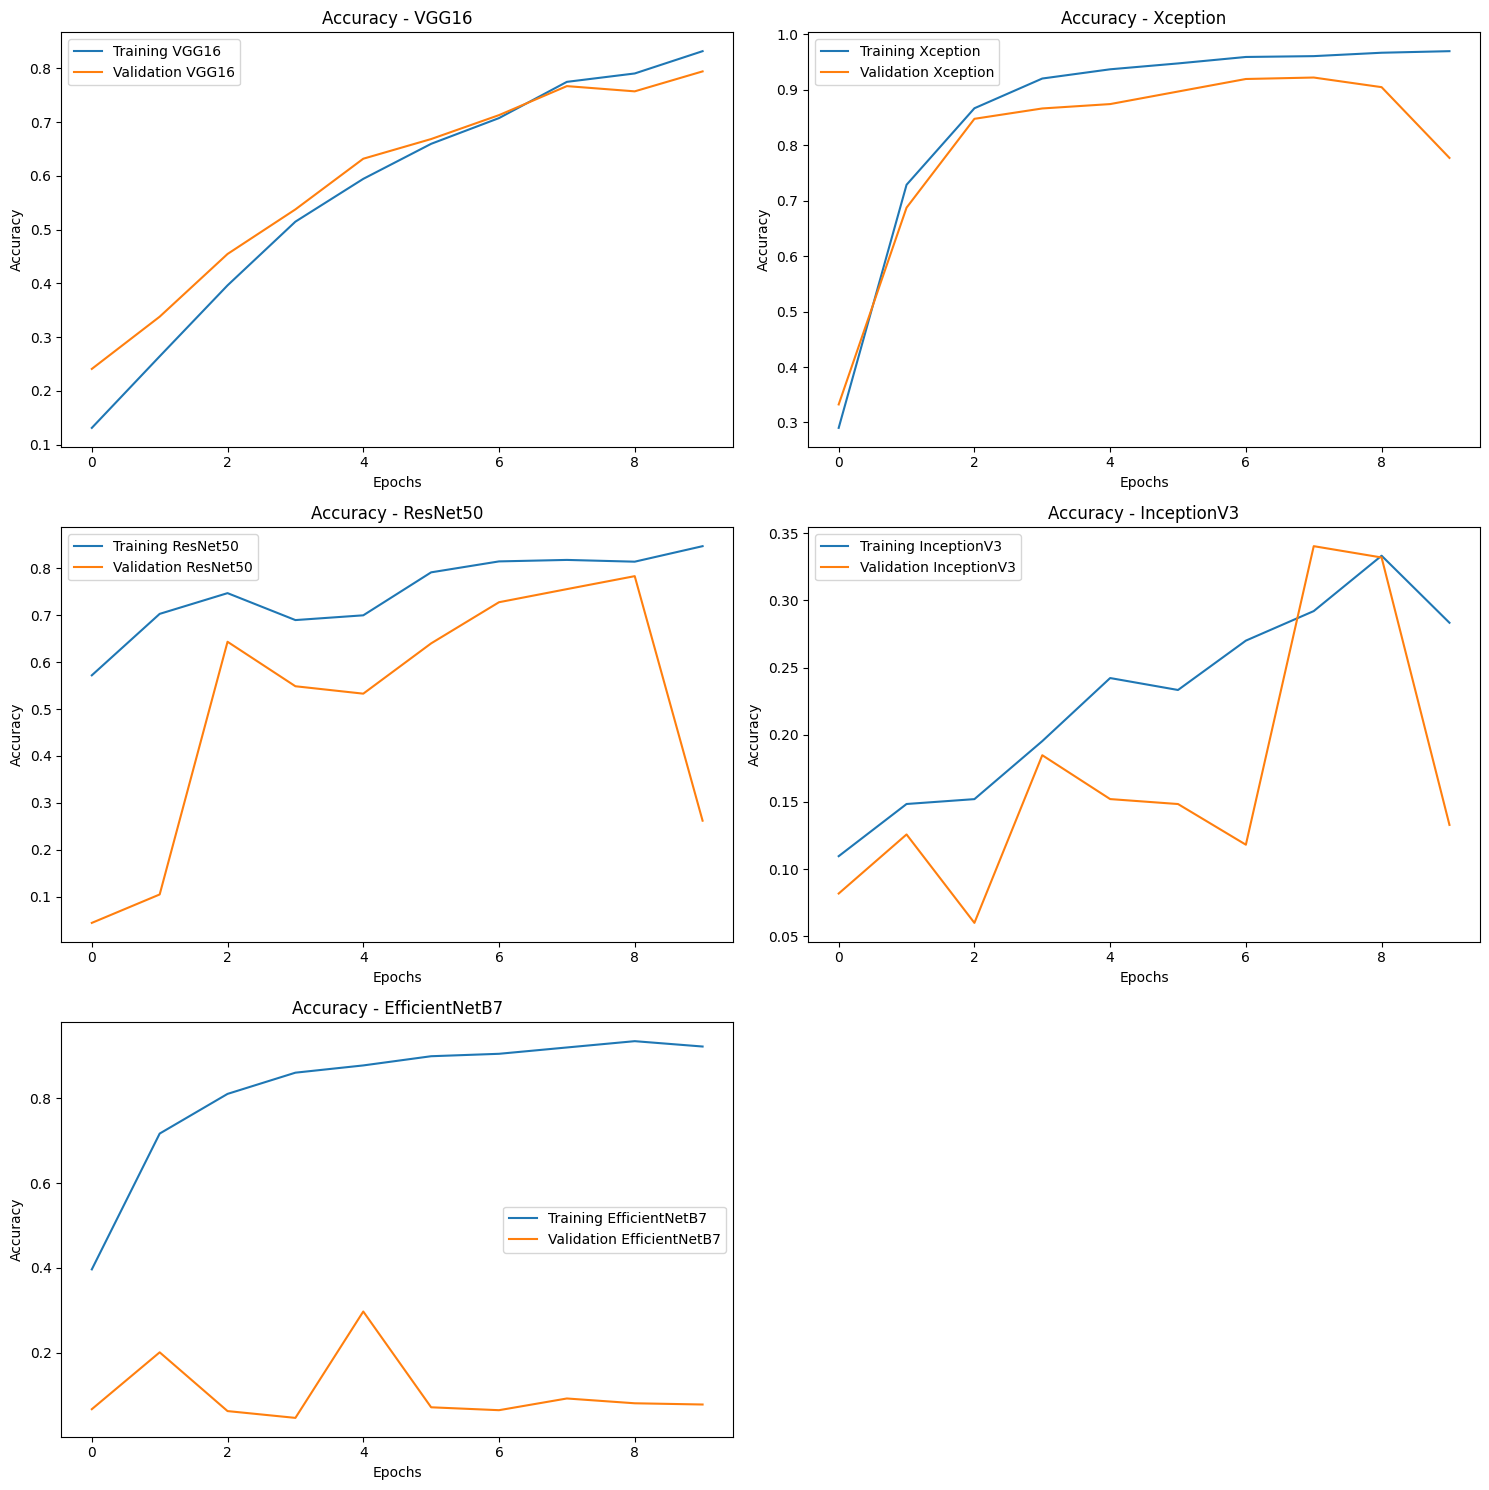

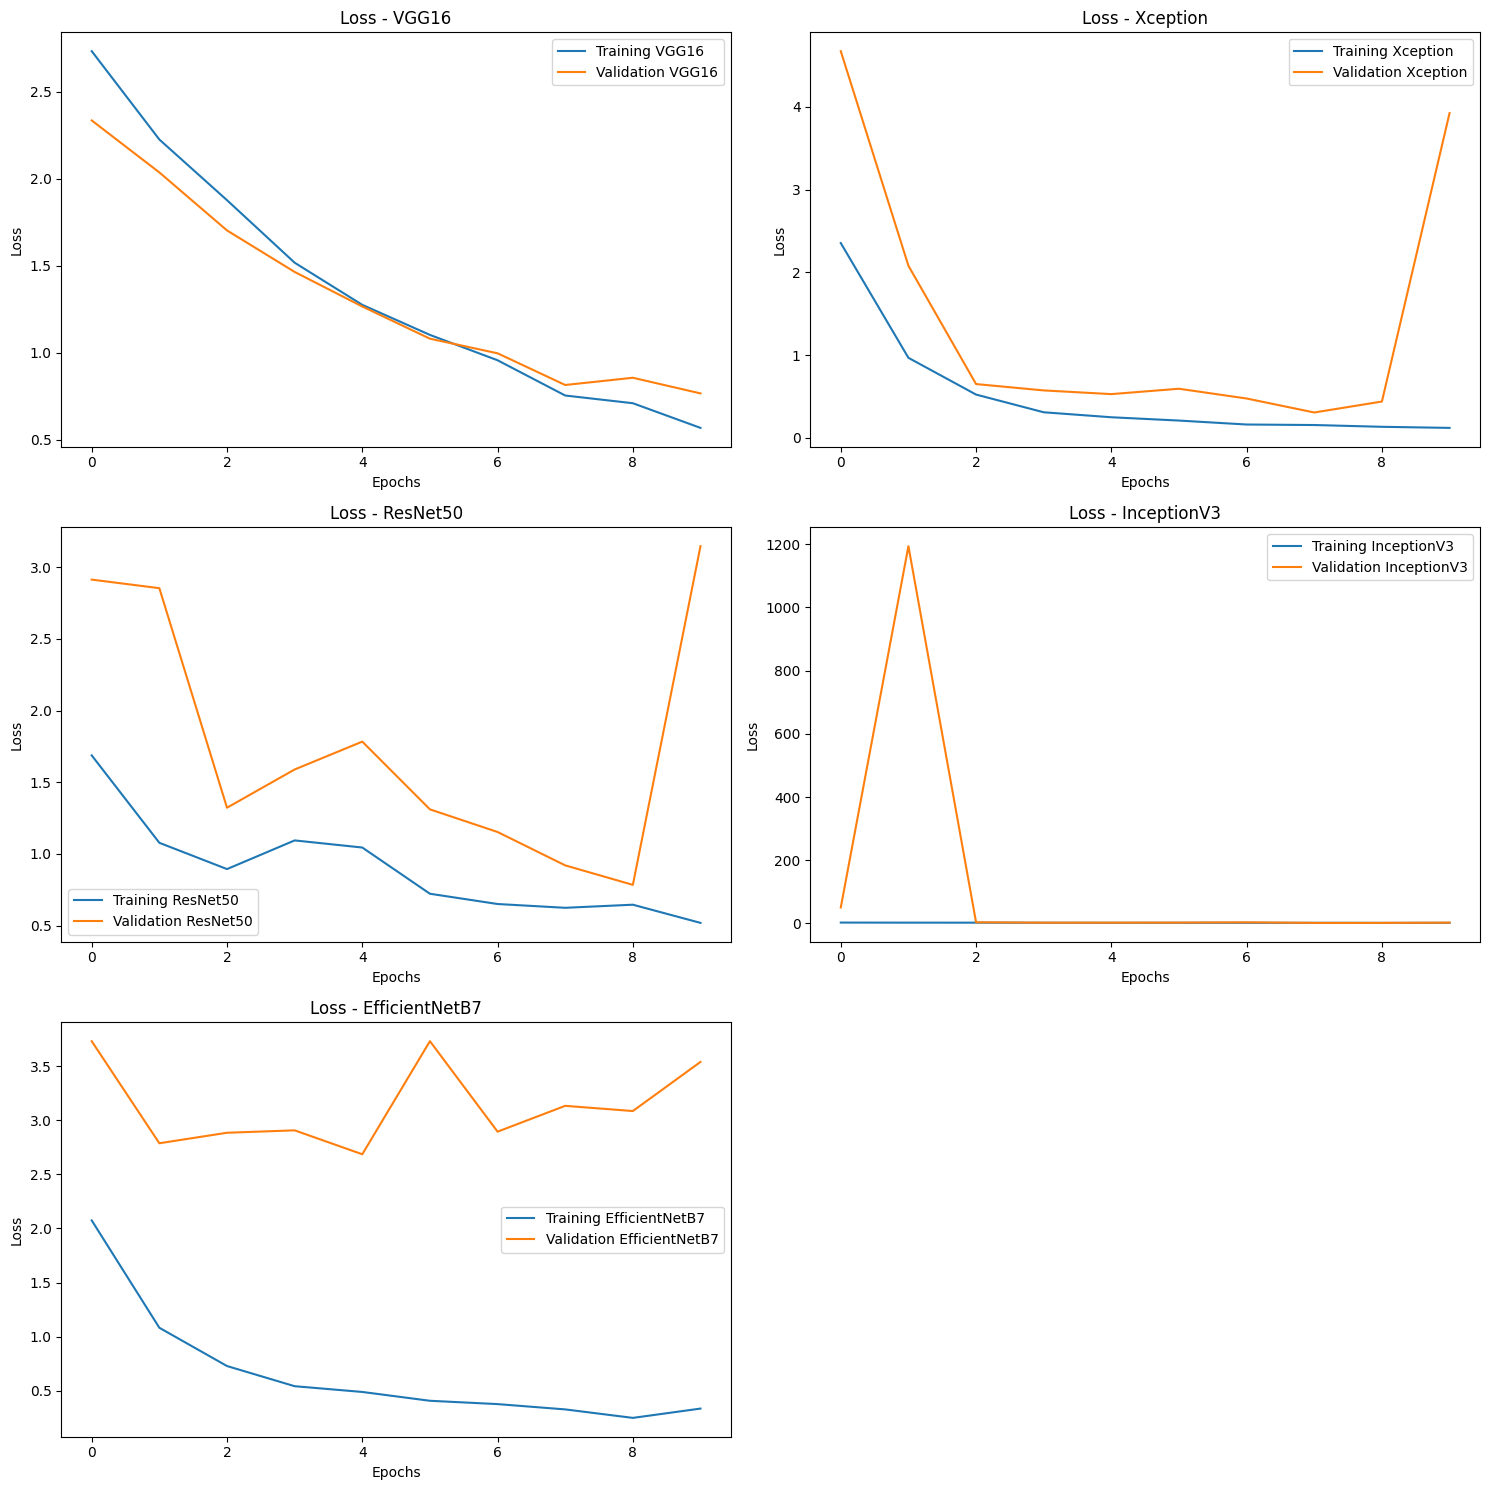

In [49]:
def plot_training_comparison(history_list, model_names, metric='accuracy'):
    num_models = len(history_list)
    num_cols = 2  # Número de columnas en la disposición de subgráficos
    num_rows = (num_models + 1) // num_cols  # Redondeo hacia arriba para asegurarse de que todos los modelos se muestren

    plt.figure(figsize=(15, 5 * num_rows))

    for i, history in enumerate(history_list):
        plt.subplot(num_rows, num_cols, i+1)
        plt.plot(history.history[metric], label=f'Training {model_names[i]}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {model_names[i]}')
        plt.title(f'{metric.capitalize()} - {model_names[i]}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()

    plt.tight_layout()
    plt.show()

# Historiales de entrenamiento de cada modelo
history_list = [vgg16_history, xception_history, resnet50_history, inceptionv3_history, efficientnetb7_history]
model_names = ['VGG16', 'Xception', 'ResNet50', 'InceptionV3', 'EfficientNetB7']

# Graficar las curvas de precisión para entrenamiento y validación por separado
plot_training_comparison(history_list, model_names, metric='accuracy')

# Graficar las curvas de pérdida para entrenamiento y validación por separado
plot_training_comparison(history_list, model_names, metric='loss')




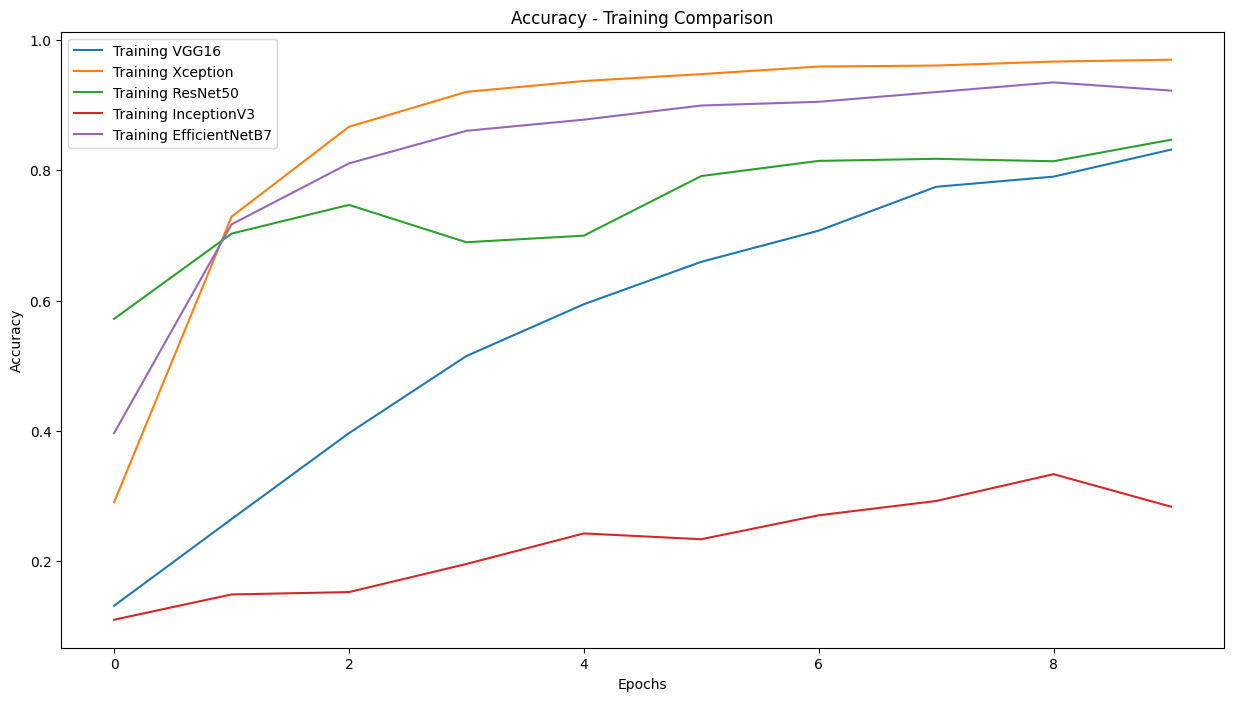

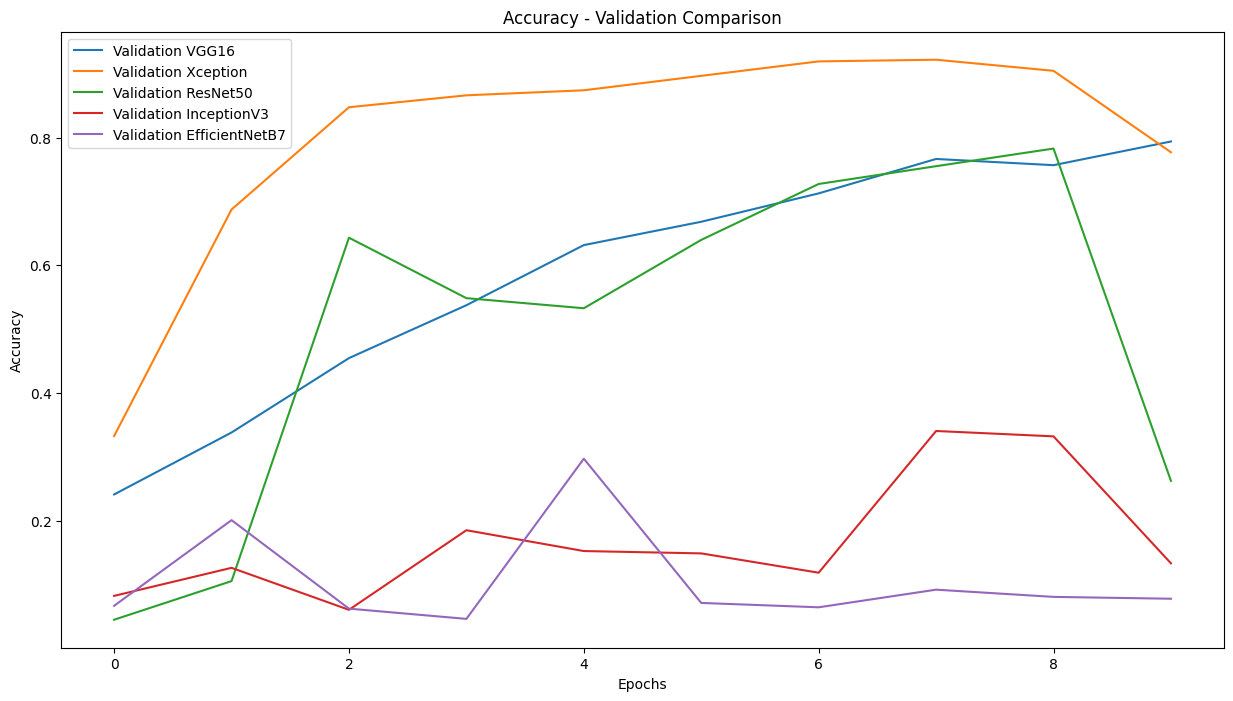

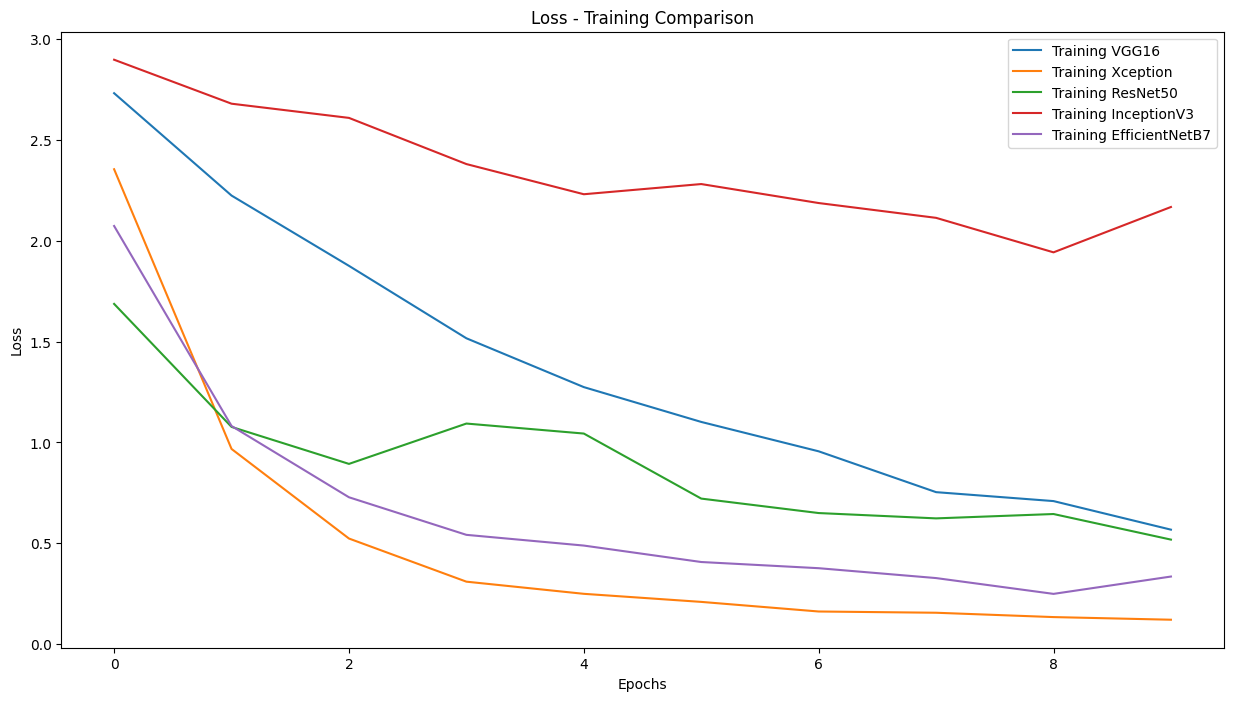

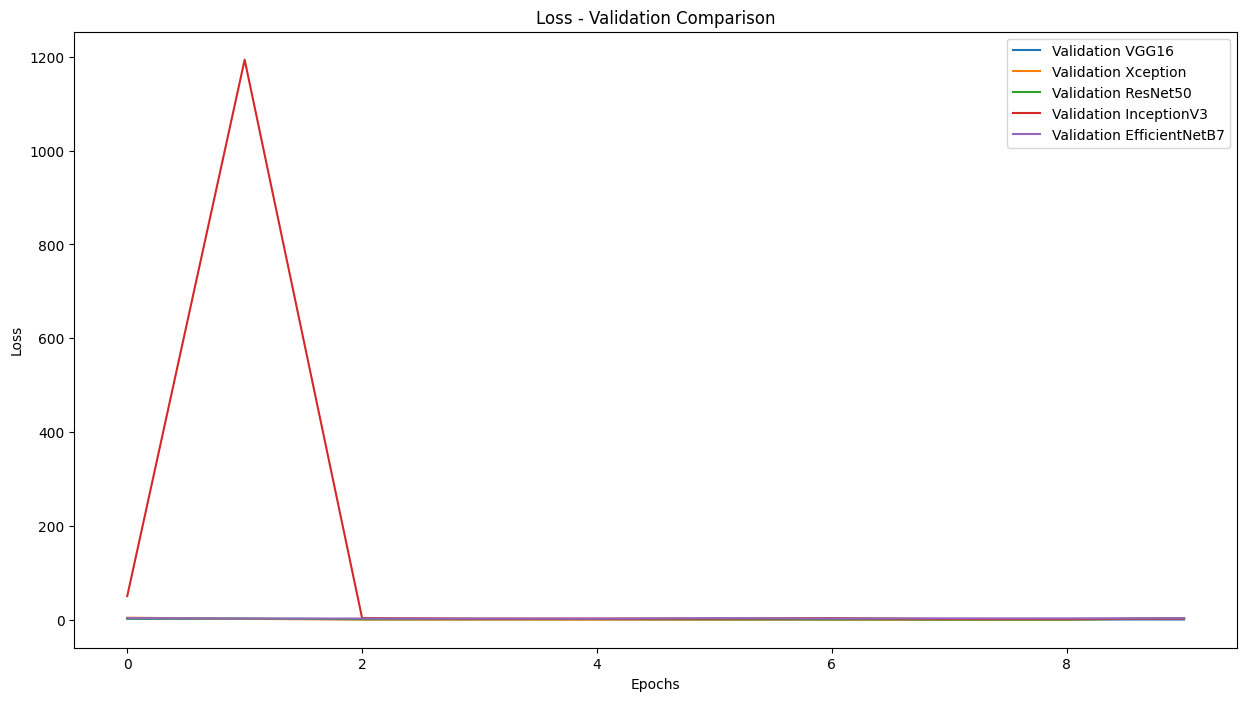

In [48]:
def plot_comparison_separate(history_list, model_names, metric='accuracy'):
    plt.figure(figsize=(15, 8))

    for i, history in enumerate(history_list):
        plt.plot(history.history[metric], label=f'Training {model_names[i]}')

    plt.title(f'{metric.capitalize()} - Training Comparison')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()

    plt.figure(figsize=(15, 8))

    for i, history in enumerate(history_list):
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {model_names[i]}')

    plt.title(f'{metric.capitalize()} - Validation Comparison')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()

# Historiales de entrenamiento de cada modelo
history_list = [vgg16_history, xception_history, resnet50_history, inceptionv3_history, efficientnetb7_history]
model_names = ['VGG16', 'Xception', 'ResNet50', 'InceptionV3', 'EfficientNetB7']

# Graficar las curvas de precisión para entrenamiento y validación por separado
plot_comparison_separate(history_list, model_names, metric='accuracy')

# Graficar las curvas de pérdida para entrenamiento y validación por separado
plot_comparison_separate(history_list, model_names, metric='loss')


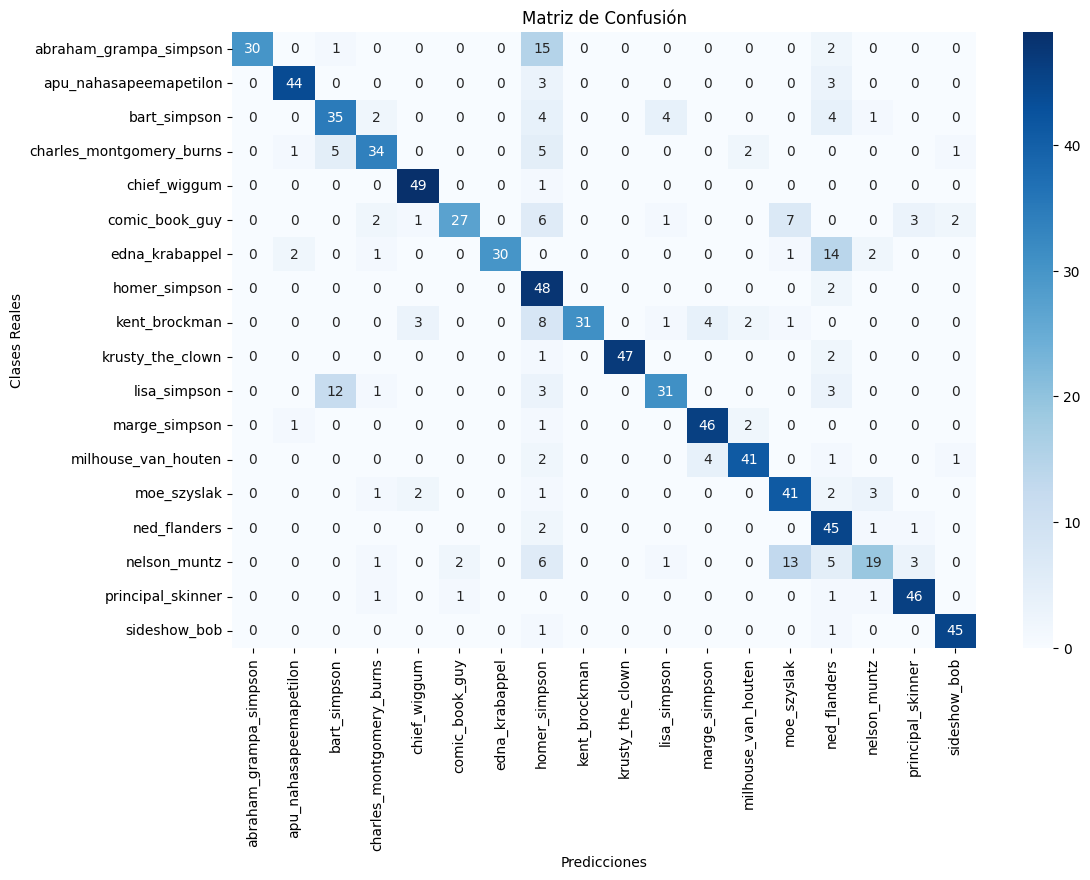

In [47]:
# Convertir las etiquetas one-hot a su forma original
y_true = np.argmax(y_t, axis=1)

# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Mostrar la matriz de confusión utilizando seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=list(MAP_CHARACTERS.values()), yticklabels=list(MAP_CHARACTERS.values()))
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Clases Reales')
plt.show()

